In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import math
from IPython.display import display
from megaman.geometry import Geometry
from megaman.embedding import (Isomap, LocallyLinearEmbedding, LTSA, SpectralEmbedding)
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import umap
from scipy.spatial import distance_matrix
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [3]:
def plot_3d_shape(datapoints, colors, title, figsize=(10, 10), set_division=False, save_path=False):
    """
    parameters
        "datapoints": Dataset used to draw the shape.
        "colors": Dataset used to color the shape; can be None.
        "title": Name of the shape.
        "figsize": size of plot, 10 * 10 as default value.
        "set_division": Choose whether set division in each axis scale;
        False as default value; if wanna set division, input real value.
        "save_path": The path for saving the plot; False as default value;
        if wanna to save plot, input absolute path for saving.
    post
        Display and save the plotted shape, generated by sklearn.
    """
    fig = plt.figure(figsize=figsize)  # set figure size
    ax = fig.add_subplot(projection='3d')

    ax.scatter(datapoints.T[0], datapoints.T[1], datapoints.T[2], c=colors, s=1)
    plt.title(title, fontsize=20)

    # rotate figure
    ax.view_init(azim=-60, elev=30)
    
    if set_division != False:
        # set division in each axis scale
        ax.xaxis.set_major_locator(ticker.MultipleLocator(set_division))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(set_division))
        ax.zaxis.set_major_locator(ticker.MultipleLocator(set_division))
    
    if save_path != False:
        plt.savefig(save_path)
    plt.show()

def plot_3d_bboxes(buildings, roads, title, figsize=(10, 10), set_division=False, save_path=False):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection='3d')

    for b in buildings:
        b.draw_bounding_box(ax, color="blue")
    for r in roads:
        r.draw_bounding_box(ax, color="gray")

    plt.title(title, fontsize=20)

    ax.view_init(azim=-60, elev=30)

    if set_division != False:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(set_division))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(set_division))
        ax.zaxis.set_major_locator(ticker.MultipleLocator(set_division))

    if save_path != False:
        plt.savefig(save_path)
    plt.show()


def plot_2d_shape_single(datapoints, colors, title, figsize=(10, 10), set_division=False, save_path=False):
    """
    parameters
        "datapoints": Dataset used to draw the shape, a matrix with 2 columns,
        returned from sklearn manifold learning methods.
        "colors": Dataset used to color the shape; can be None.
        "title": Name of the shape.
        "figsize": size of plot, 10 * 10 as default value.
        "set_division": Choose whether set division in each axis scale;
        False as default value; if wanna set division, input real value.
        "save_path": The path for saving the plot; False as default value;
        if wanna to save plot, input absolute path for saving.
    post
        Plot and save the 2d shape, through data in "datapoints".
    """
    x, y = datapoints.T
    plt.figure(figsize=figsize)
    plt.scatter(x, y, c=colors, s=20, alpha=0.8)
    plt.title(title, fontsize=20)

    if set_division != False:
        # set division in each axis scale
        ax.xaxis.set_major_locator(ticker.MultipleLocator(set_division))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(set_division))

    if save_path != False:
        plt.savefig(save_path)

    plt.axis('off')
    plt.show()


def plot_2d_shape_all(datapoints, colors, title, size=5, figsize=(20, 20), set_division=False, save_path=False):
    """
    parameters
        "datapoints": Returned matrix from sklearn manifold learning methods, for plotting.
        "colors": Dataset used to color each shape; can be None.
        "size": size of dots
        "title": Name of the plot.
        "figsize": size of plot, 20 * 20 as default value.
        "set_division": Choose whether set division in each axis scale;
        False as default value; if wanna set division, input real value.
        "save_path": The path for saving the plot; False as default value;
        if wanna to save plot, input absolute path for saving.
    post
        Plot and save all 2d shapes; each shape is plotted by combining first and
        another column in "datapoints".
    """
    num_of_plots = datapoints.shape[-1] - 1
    fig = plt.figure(figsize=figsize)
    
    for i in range(1, num_of_plots+1):
        sub_data = datapoints[:, [0,i]]
        x, y = sub_data.T
        ax = fig.add_subplot(math.ceil(num_of_plots/2), 2, i)
        ax.scatter(x, y, c=colors, s=size)

        if set_division != False:
            # set division in each axis scale
            ax.xaxis.set_major_locator(ticker.MultipleLocator(set_division))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(set_division))
    
    plt.suptitle(title, fontsize=20)
    if save_path != False:
        plt.savefig(save_path)
    plt.show()

In [4]:
class Building:
    def __init__(self, x, y, width, length, height):
        self.x = x
        self.y = y
        self.width = width
        self.length = length
        self.height = height
        self.volume = width * length * height
        
    def contains_point(self, point):
        px, py, pz = point
        return (self.x <= px <= self.x + self.width and
                self.y <= py <= self.y + self.length and
                0 <= pz <= self.height)
    
    def sample_uniformly(self, n_points):
        points = np.zeros((n_points, 3))
        points[:, 0] = np.random.uniform(self.x, self.x + self.width, n_points)
        points[:, 1] = np.random.uniform(self.y, self.y + self.length, n_points)
        points[:, 2] = np.random.uniform(0, self.height, n_points)
        return points

    def draw_bounding_box(self, ax, color="b"):
        x, y, w, l, h = self.x, self.y, self.width, self.length, self.height
        # Refine logic later
        c = np.array([
            [x, y, 0],
            [x+w, y, 0],
            [x+w, y+l, 0],
            [x, y+l, 0],
            [x, y, h],
            [x+w, y, h],
            [x+w, y+l, h],
            [x, y+l, h]
        ])
        edges = [(0,1),(1,2),(2,3),(3,0),(4,5),(5,6),(6,7),(7,4),(0,4),(1,5),(2,6),(3,7)]
        for i,j in edges:
            ax.plot([c[i,0],c[j,0]], [c[i,1],c[j,1]], [c[i,2],c[j,2]], color=color)



class Road:
    def __init__(self, x, y, width, length, angle=0.0):
        self.x = x
        self.y = y
        self.width = width
        self.length = length
        self.height = 1.0
        self.angle = angle
        self.volume = width * length

    def contains_point(self, point):
        px, py, pz = point
        if not (0 <= pz <= self.height):
            return False
        
        tx = px - self.x
        ty = py - self.y

        cos_a = np.cos(-self.angle)
        sin_a = np.sin(-self.angle)
        rx = tx * cos_a - ty * sin_a
        ry = tx * sin_a + ty * cos_a

        return (0 <= rx <= self.length) and (0 <= ry <= self.width)

    def sample_uniformly(self, n_points):
        points = np.zeros((n_points, 3))
        lengths = np.random.uniform(0, self.length, n_points)
        widths = np.random.uniform(0, self.width, n_points)
        heights = np.random.uniform(0, self.height, n_points)

        cos_a = np.cos(self.angle)
        sin_a = np.sin(self.angle)

        points[:, 0] = self.x + lengths * cos_a - widths * sin_a
        points[:, 1] = self.y + lengths * sin_a + widths * cos_a
        points[:, 2] = heights

        return points

    def draw_bounding_box(self, ax, color="g"):
        # Refine logic later
        l, w, h = self.length, self.width, self.height
        c = np.array([
            [0, 0, 0],
            [l, 0, 0],
            [l, w, 0],
            [0, w, 0],
            [0, 0, h],
            [l, 0, h],
            [l, w, h],
            [0, w, h]
        ])

        cos_a, sin_a = np.cos(self.angle), np.sin(self.angle)
        R = np.array([
            [cos_a, -sin_a, 0],
            [sin_a, cos_a, 0],
            [0, 0, 1]
        ])

        corners = (c @ R.T) + np.array([self.x, self.y, 0])

        edges = [(0,1),(1,2),(2,3),(3,0),(4,5),(5,6),(6,7),(7,4),(0,4),(1,5),(2,6),(3,7)]
        for i,j in edges:
            ax.plot([corners[i,0], corners[j,0]],
                    [corners[i,1], corners[j,1]],
                    [corners[i,2], corners[j,2]], color=color)



In [5]:
np.random.seed(42) 

buildings = [
    Building(0, 0, 3, 5, 10), 
    Building(8, 0, 2, 2, 15), 
    Building(15, 5, 4, 3, 8), 
    Building(0, 10, 2, 4, 12), 
    Building(8, 12, 3, 3, 6), 
    Building(15, 15, 5, 2, 20), 
]

roads = [
    Road(x=1.5, y=2.5, width=1.0, length=7.211, angle=-0.2),
    Road(x=9.0, y=1.0, width=2.0, length=9.434, angle=0.6),
    Road(x=2.5, y=5, width=2.0, length=5.280, angle=1.6),
    Road(x=1.0, y=12.0, width=2.0, length=7.615, angle=0),
    Road(x=17.0, y=6.5, width=1.0, length=9, angle=1.5),
    Road(x=9.5, y=15.5, width=1.0, length=5, angle=0),
]

total_building_volume = sum(building.volume for building in buildings)
total_road_volume = sum(road.volume for road in roads)
total_volume = total_building_volume + total_road_volume

In [6]:
def sample_city(buildings, roads, n_samples):
    structures = buildings + roads
    volumes = np.array([s.volume for s in structures], dtype=float)
    probabilities = volumes / volumes.sum()
    points_per_structure = np.random.multinomial(n_samples, probabilities)
    
    all_points = []
    labels = []
    
    for i, structure in enumerate(structures):
        n_pts = points_per_structure[i]
        if n_pts > 0:
            pts = structure.sample_uniformly(n_pts)
            all_points.append(pts)
            
            if i < len(buildings):
                labels.extend([f"Building_{i+1}"] * n_pts)
            else:
                labels.extend([f"Road_{i+1-len(buildings)}"] * n_pts)
    
    points = np.vstack(all_points)
    
    return points, labels


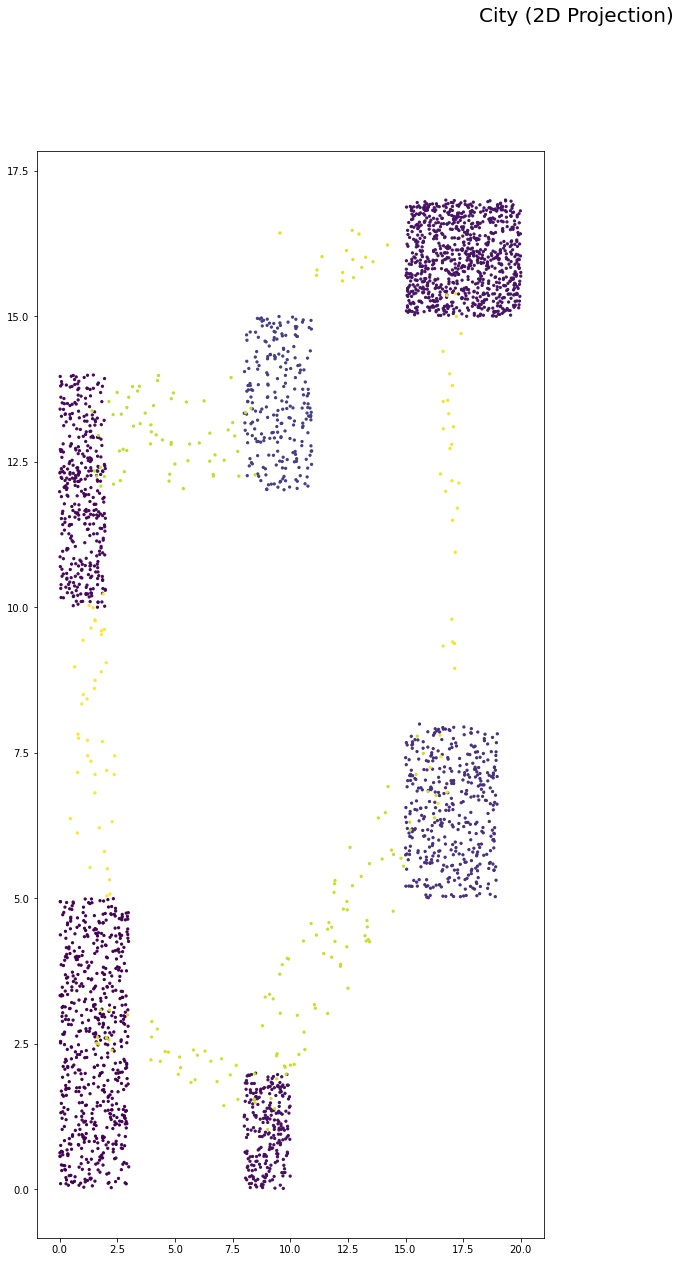

In [7]:
n_samples = 3000
data_3d, labels = sample_city(buildings, roads, n_samples)
data = np.delete(data_3d, 2, axis=1)

unique_labels = list(set(labels))
city_colors = np.zeros(len(labels))
for i, label in enumerate(unique_labels):
    if label.startswith("Building"):
        city_colors[np.array(labels) == label] = i
    else:
        city_colors[np.array(labels) == label] = 50 + i



# plot_3d_shape(data_3d, city_colors, "City (3D Projection)")

# plot_3d_bboxes(buildings, roads, title="City Bounding Boxes", set_division=10)

plot_2d_shape_all(data, city_colors, "City (2D Projection)",
    figsize=(20, 20),
    set_division=False)

In [8]:

# plot embedding and rmetric copied from Review-figures.ipynb
large_dot=True
dot_size=5 if large_dot else 1

class PlotResult():
    def __init__(self,embedding_method,data,dimension,radius,n_neighbors):
        self.embedding_method = embedding_method
        self.data = data
        self.d = dimension
        self.embedded_data = np.zeros(data.shape)
        self.H = np.zeros((data.shape[0],dimension,dimension))
        self.radius=radius
        self.n_neighbors=n_neighbors
        self.figures={}
        
    def compute_geom(self):
        data = self.data
        d = self.d
        adjacency_method = 'brute'
        adjacency_kwds = {'n_neighbors': self.n_neighbors}
        affinity_method = 'gaussian'
        affinity_kwds = {'radius': self.radius}
        laplacian_method = 'geometric'
        laplacian_kwds = {'scaling_epps': self.radius}

        geom = Geometry(
            adjacency_method=adjacency_method,
            adjacency_kwds=adjacency_kwds,
            affinity_method=affinity_method,
            affinity_kwds=affinity_kwds,
            laplacian_method=laplacian_method,
            laplacian_kwds=laplacian_kwds
        )

        geom.set_data_matrix(data)
        laplacian_matrix = geom.compute_laplacian_matrix()
        
        if self.embedding_method == 'Isomap':
            isomap = Isomap(n_components=d, eigen_solver='arpack', geom=geom)
            self.embedded_data = isomap.fit_transform(data)
        
        elif self.embedding_method == 'LE':
            spectral = SpectralEmbedding(n_components=d, eigen_solver='arpack',geom=geom)
            self.embedded_data = spectral.fit_transform(data)
            
        elif self.embedding_method == 'LTSA':
            ltsa = LTSA(n_components=d, eigen_solver='dense',geom=geom)
            self.embedded_data = ltsa.fit_transform(data)
            
        elif self.embedding_method == 'LLE':
            lle = LocallyLinearEmbedding(n_components=d, eigen_solver='arpack', geom=geom)
            self.embedded_data = lle.fit_transform(data)
            
        elif self.embedding_method == 't-SNE':
            tsne = TSNE(n_components=d, init='pca', random_state=0)
            self.embedded_data = tsne.fit_transform(data)
            
        elif self.embedding_method == 'Umap':
            reducer = umap.UMAP(n_neighbors=self.n_neighbors, min_dist=0.1, n_components=d, metric='euclidean')
            self.embedded_data = reducer.fit_transform(data)
            
        else:
            print('No such method!')
            return 
    
    def plot_result(self,n_plot,rellip,seed,point_size=dot_size,point_color='blue',landmark_indices=None,rotate=0, horizontal_flip=False):
        rng = np.random.RandomState(seed)
        sample_points = rng.choice(range(self.data.shape[0]), n_plot, replace = False)       
        f1, ax = plt.subplots(figsize=(8,8))
        data = self.embedded_data.copy()

        if horizontal_flip:
            data[:, 0] = -data[:, 0]
        if rotate:
            data = np.dot(data, np.array([[np.cos(rotate), -np.sin(rotate)], [np.sin(rotate), np.cos(rotate)]]))

        ax.scatter(data[:, 0], data[:, 1], s = point_size,c=point_color)
        if landmark_indices is not None:
            for landmark_id, point_indices in landmark_indices.items():
                x_mean = data[point_indices, 0].mean()
                y_mean = data[point_indices, 1].mean()
                ax.text(x_mean, y_mean, landmark_id, fontsize=8, ha='left', va='bottom', weight='bold')
        ax.set_axis_off()
        f1.tight_layout()
        self.figures['figure'] = f1

    %matplotlib widget
    def interactive_plot(self, rellip, point_size, point_color='blue'):
        fig, ax = plt.subplots(figsize=(8,8))
        scatter = ax.scatter(self.embedded_data[:, 0], self.embedded_data[:, 1], s=point_size, c=point_color, picker=True)

        self.ellip_artist = None
        
        fig.canvas.mpl_connect('motion_notify_event', on_hover)
        ax.set_axis_off()
        fig.tight_layout()
        plt.show()

    def plot_radius(self, cropped_indices ,samples,rellip,point_size=dot_size,point_color='blue'):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.scatter(self.embedded_data[cropped_indices, 0], self.embedded_data[cropped_indices, 1], s = point_size,c=point_color)
        ax.set_aspect('equal')
        ax.set_axis_off()
        fig.tight_layout()
        plt.show()

    def plot_3d(self,point_size=dot_size,point_color='blue'):
        fig, ax = plt.subplots(subplot_kw={'projection': '3d'},figsize=(8,8))

        # Scatter plot
        sc = ax.scatter(self.data[:,1], self.data[:,3], self.data[:,5], s=point_size, c=point_color, cmap='viridis')

        # Adding color bar
        cbar = plt.colorbar(sc)
        cbar.set_label('Color Scale')

        # Setting labels
        ax.set_xlabel('1-evec')
        ax.set_ylabel('3-evec')
        ax.set_zlabel('5-evec')
        # Showing the plot
        plt.show()
            

In [9]:
def min_radius_for_neighbors(data):
    """
    Returns smallest radius such that every point has at least one neighbor.
    """
    D = distance_matrix(data, data)
    np.fill_diagonal(D, np.inf)
    nearest_distances = D.min(axis=1)
    radius = nearest_distances.max()
    return radius

radius = min_radius_for_neighbors(data) + 0.2

{'figure': <Figure size 800x800 with 1 Axes>}

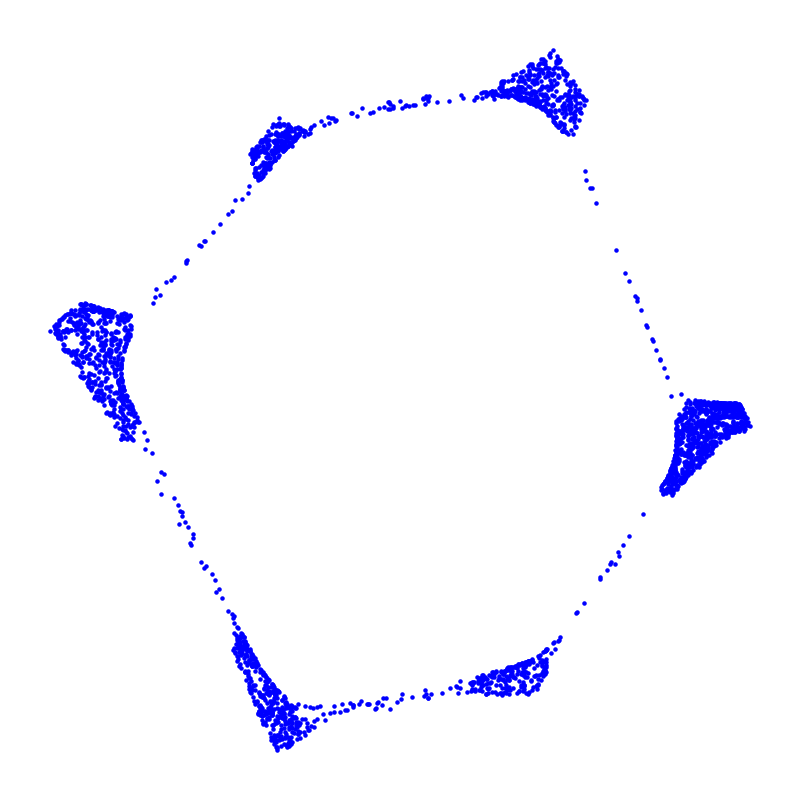

In [10]:
city_isomap = PlotResult(embedding_method='Isomap',data=data,dimension=2,radius=radius,n_neighbors=10)
city_isomap.compute_geom()
city_isomap.plot_result(20,0.0025,2014012168)
city_isomap.figures

{'figure': <Figure size 800x800 with 1 Axes>}

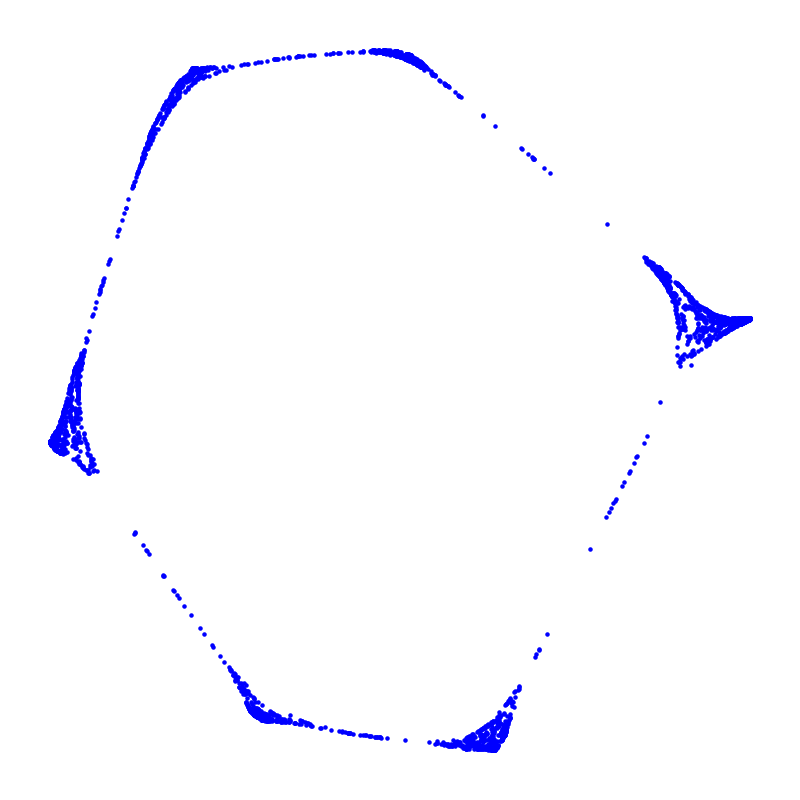

In [11]:
city_le = PlotResult(embedding_method='LE',data=data,dimension=2,radius=radius, n_neighbors=10)
city_le.compute_geom()
city_le.plot_result(20,0.0025,2014012168)
city_le.figures

{'figure': <Figure size 800x800 with 1 Axes>}

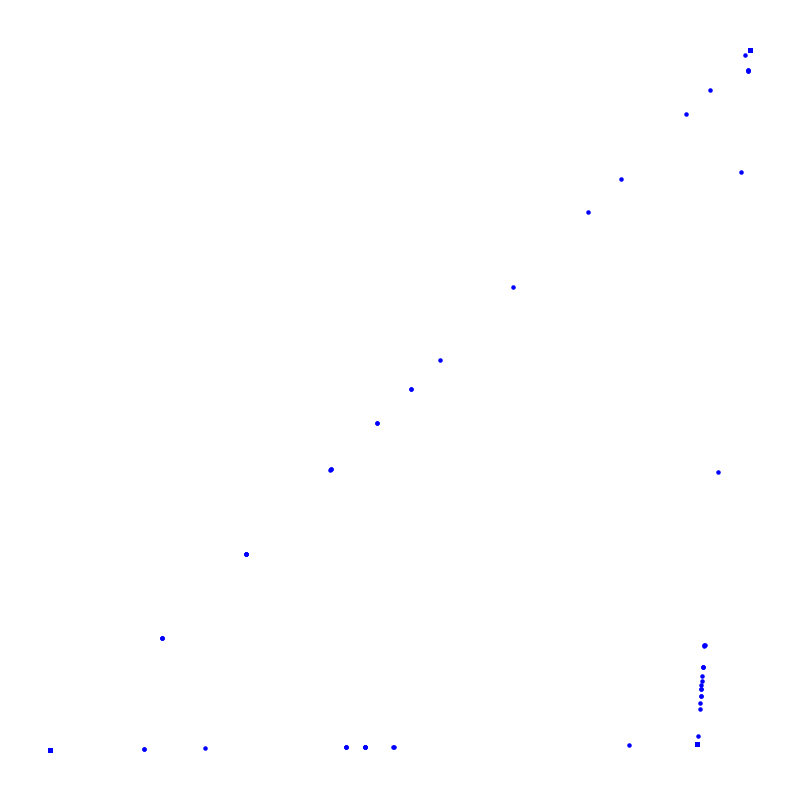

In [12]:
city_lle = PlotResult(embedding_method='LLE',data=data,dimension=2,radius=radius,n_neighbors=10)
city_lle.compute_geom()
city_lle.plot_result(20,0.0025,2014012168)
city_lle.figures

{'figure': <Figure size 800x800 with 1 Axes>}

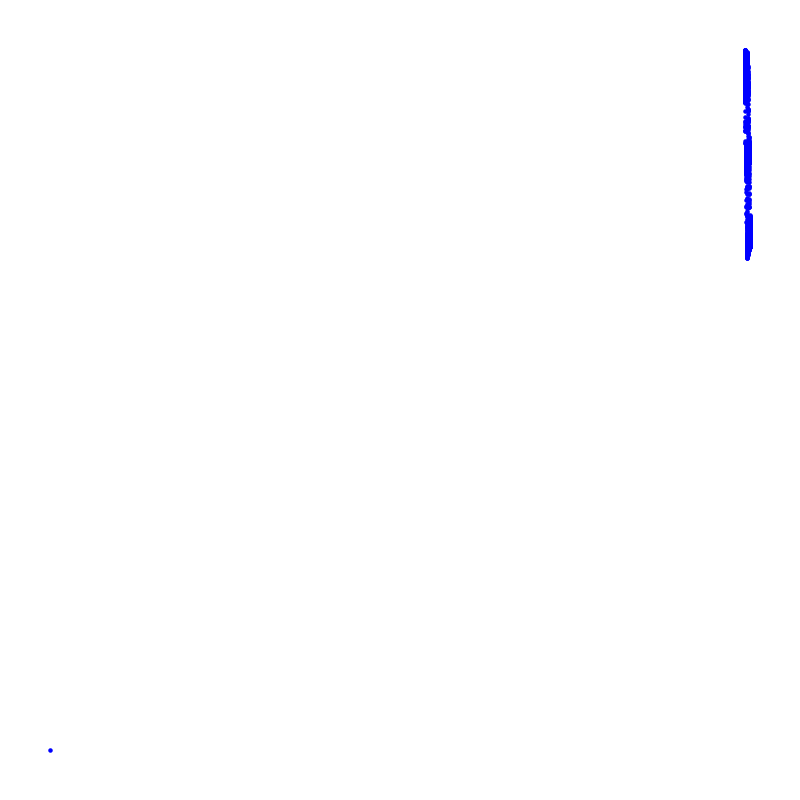

In [13]:
city_ltsa = PlotResult(embedding_method='LTSA',data=data,dimension=2,radius=radius,n_neighbors=10)
city_ltsa.compute_geom()
city_ltsa.plot_result(20,0.0025,2014012168)
city_ltsa.figures

{'figure': <Figure size 800x800 with 1 Axes>}

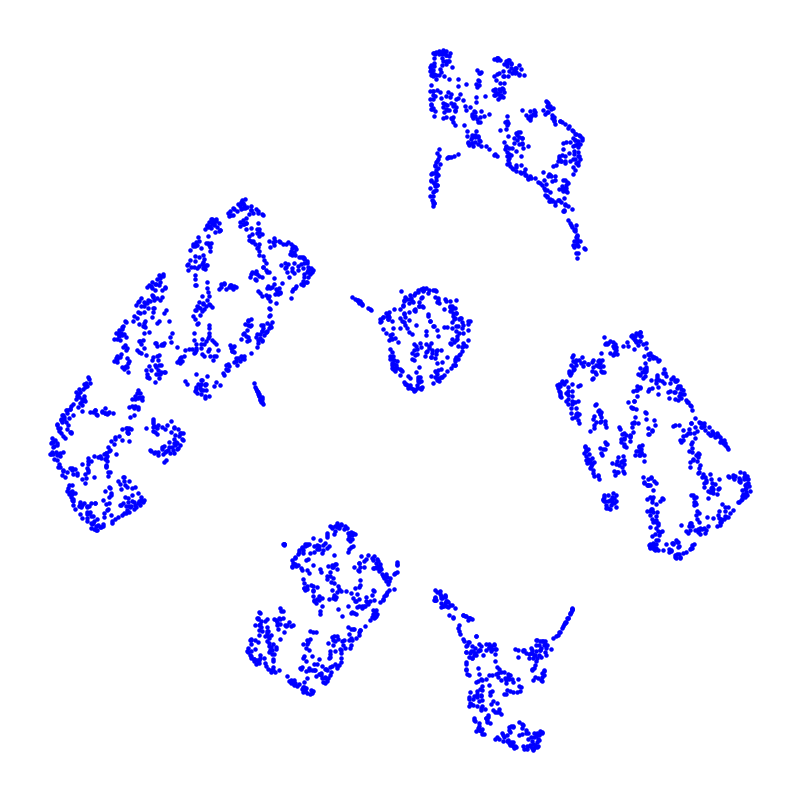

In [14]:
city_tsne = PlotResult(embedding_method='t-SNE',data=data,dimension=2,radius=radius,n_neighbors=10)
city_tsne.compute_geom()
city_tsne.plot_result(20,0.0025,2014012168)
city_tsne.figures

{'figure': <Figure size 800x800 with 1 Axes>}

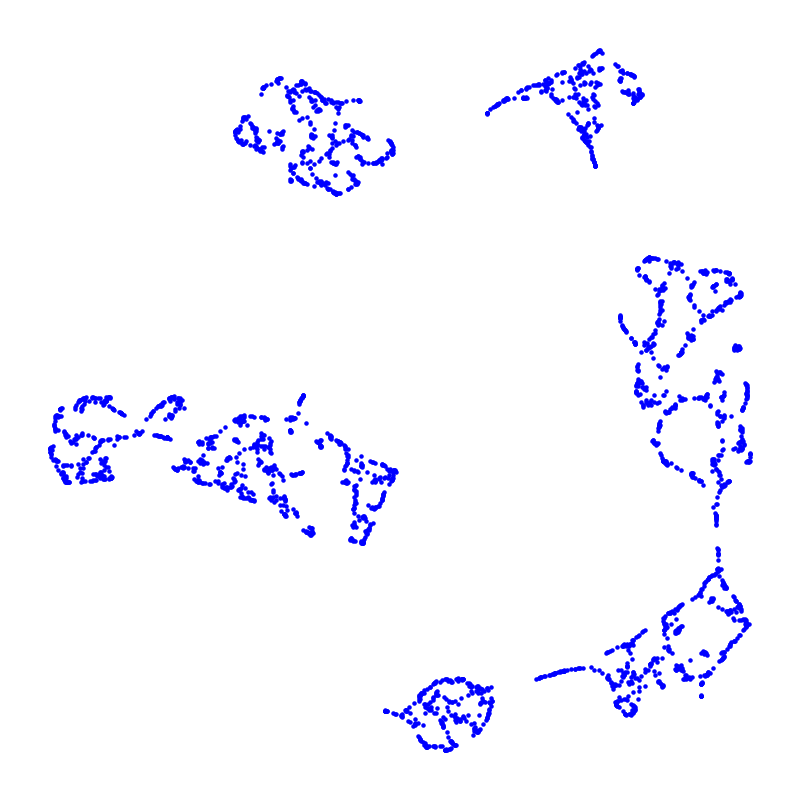

In [15]:
city_umap = PlotResult(embedding_method='Umap',data=data,dimension=2,radius=radius,n_neighbors=10)
city_umap.compute_geom()
city_umap.plot_result(20,0.0025,2014012168)
city_umap.figures

# UW Map

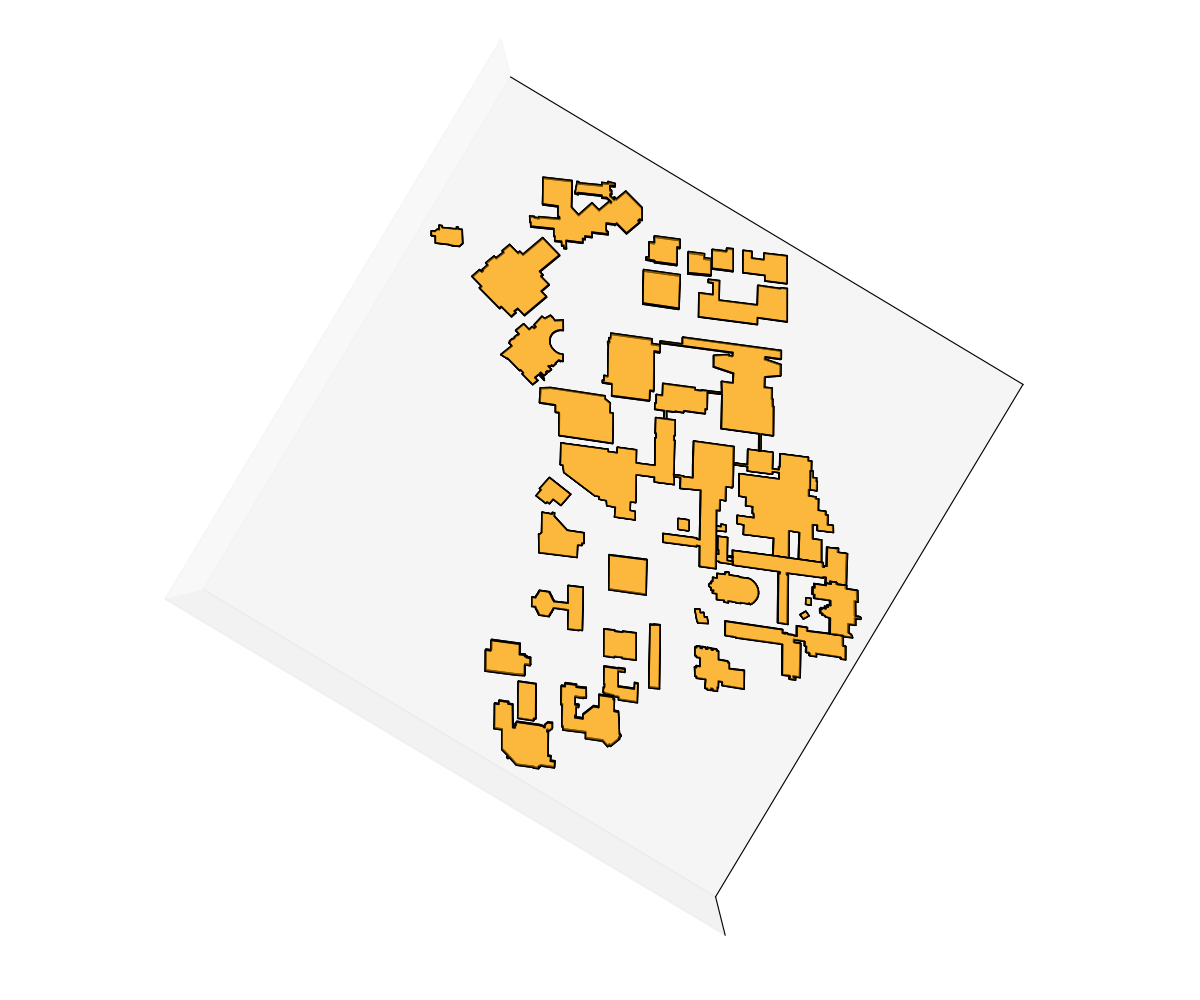

In [18]:


buildings = gpd.read_file("WaterlooBuildingFootprints.geojson")

ring_road_building = {
    115893: "Health", 
    116752: "Science", 
    116075: "Other", 
    116713: "Other", 
    116714: "Other", 
    116228: "Other", 
    211666: "Math", 
    115889: "Other", 
    115890: "Other", 
    115891: "Other", 
    116074: "Math", 
    116076: "Science", 
    115894: "Math", 
    116110: "Science", 
    116231: "Science", 
    116113: "Engineering", 
    116077: "Engineering", 
    116078: "Environment", 
    115899: "Science", 
    115898: "Science", 
    115900: "Science", 
    116080: "Engineering", 
    116071: "Engineering", 
    238047: "Other", 
    116724: "Engineering", 
    116238: "Engineering", 
    116236: "Engineering", 
    116081: "Engineering", 
    116227: "Other", 
    115896: "Other", 
    116712: "Other", 
    116073: "Arts", 
    115888: "Arts", 
    116711: "Arts", 
    116072: "Other", 
    116111: "Other", 
    116726: "Other", # Not sure where it is 
    115887: "Arts", 
    116235: "Environment", 
    116313: "Environment", 
    115897: "Arts", 
}
# Source: https://uwaterloo.ca/brand/how-express-our-brand/colour
faculty_colors_map = {
    "Math": (0.875, 0.102, 0.627),
    "Engineering": (0.525, 0.365, 0.643),
    "Health": (0.0, 0.612, 0.659), 
    "Science": (0.0, 0.447, 0.855),
    "Other": (0.8, 0.8, 0.8),
    "Arts": (0.929, 0.549, 0.0),
    "Environment": (0.518, 0.749, 0.0)
}
landmarks = {
    115894: "DC",
    116074: "MC",
    116081: "DWE",
    115896: "DP"
}
buildings = buildings[buildings["OBJECTID"].isin(ring_road_building.keys())]
buildings["Faculty"] = buildings["OBJECTID"].map(ring_road_building)

flattened_rows = []

# Flatten MultiPolygons into Polygons
for _, row in buildings.iterrows():
    geom = row.geometry
    if isinstance(geom, Polygon):
        flattened_rows.append(row) 
    elif isinstance(geom, MultiPolygon):
        for sub_poly in geom.geoms:
            new_row = row.copy()
            new_row.geometry = sub_poly 
            flattened_rows.append(new_row)

buildings = gpd.GeoDataFrame(flattened_rows, columns=buildings.columns, crs=buildings.crs)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")


def draw_building(ax, footprint, height, color="orange"):
    x, y = footprint.exterior.xy
    verts = []

    for i in range(len(x) - 1):
        verts.append([
            (x[i], y[i], 0),
            (x[i + 1], y[i + 1], 0),
            (x[i + 1], y[i + 1], height),
            (x[i], y[i], height),
        ])

    verts.append([(x[i], y[i], height) for i in range(len(x))])
    verts.append([(x[i], y[i], 0) for i in range(len(x))])

    ax.add_collection3d(
        Poly3DCollection(verts, facecolors=color, edgecolors="k", alpha=0.5)
    )

for _, row in buildings.iterrows():
    height = float(row.get("HeightRela", 10))
    draw_building(ax, row.geometry, height)

minx, miny, maxx, maxy = buildings.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_zlim(0, 200)

ax.view_init(elev=90, azim=300)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.tight_layout()
plt.show()

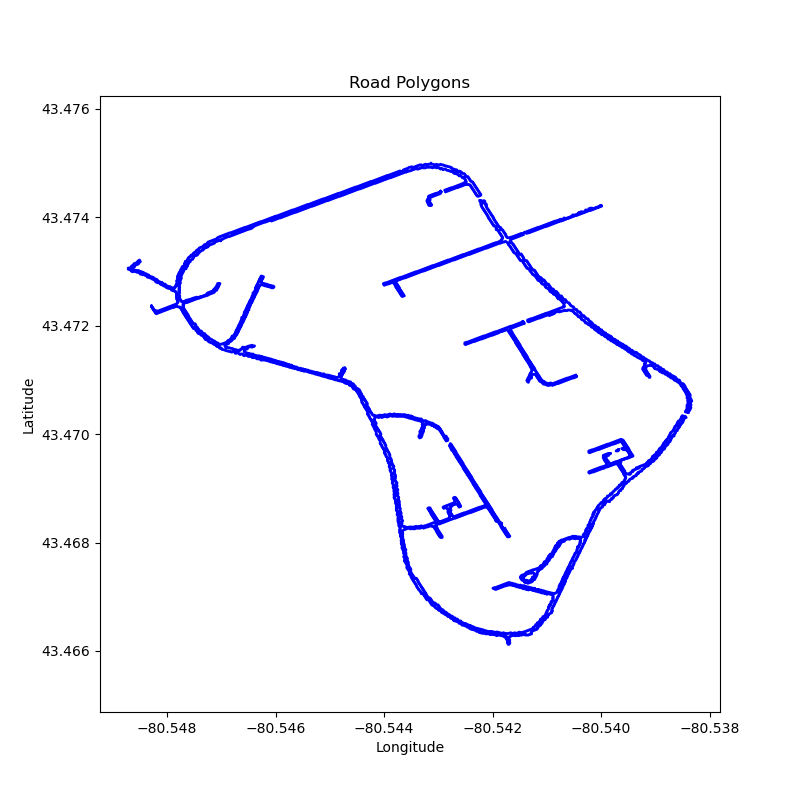

In [20]:
# Ring Road Extraction

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from shapely.geometry import Polygon

img = Image.open("ring_road.png").convert("RGB")
arr = np.array(img)

red_pixels = np.where((arr[:, :, 0] > 220) & (arr[:, :, 1] < 80) & (arr[:, :, 2] < 80))

H, W = arr.shape[:2]
mask = np.zeros((H, W), dtype=np.uint8)
mask[red_pixels[0], red_pixels[1]] = 255

lon_min, lon_max = -80.5494, -80.5357
lat_min, lat_max= 43.4648, 43.4765
scale_x = (lon_max - lon_min) / (W - 1) # Look into these calculations. 
scale_y = (lat_min - lat_max) / (H - 1)

contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
roads = [
    Polygon(
        np.column_stack([
            lon_min + c[:, 0, 0] * scale_x,
            lat_max + c[:, 0, 1] * scale_y
        ])
    )
    for c in contours if len(c) >= 3
]

plt.figure(figsize=(8, 8))
for poly in roads:
    x, y = poly.exterior.xy
    plt.plot(x, y, color='blue', linewidth=2)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Road Polygons")
plt.axis('equal')
plt.show()

In [24]:
from shapely.geometry import Point, Polygon, MultiPolygon
def sample_points_in_polygon(polygon, n_points):
    """
    Sample n_points uniformly inside a polygon.
    Works for Polygon only.
    """
    minx, miny, maxx, maxy = polygon.bounds
    points = []

    while len(points) < n_points:
        x = np.random.uniform(minx, maxx)
        y = np.random.uniform(miny, maxy)
        pt = Point(x, y)
        if polygon.contains(pt):
            points.append(pt)

    return points


poly = buildings.geometry.iloc[0] 
sampled_points = sample_points_in_polygon(poly, 100)
points = [(p.x, p.y) for p in sampled_points]

In [34]:
def sample_city(buildings, roads, n_samples_building, n_samples_road):
    # Sampling Buildings
    all_points = []
    labels = []
    colors = []
    landmark_indices = {}

    volumes = np.array(buildings["Shape_Area"] * buildings["HeightRela"], dtype=float)
    probabilities = volumes / volumes.sum()
    points_per_building = np.random.multinomial(n_samples_building, probabilities)
    point_idx = 0
    for i, building in enumerate(buildings.itertuples()):
        n_pts = points_per_building[i]
        if n_pts > 0:
            pts = sample_points_in_polygon(building.geometry, n_pts)
            all_points.extend([(p.x, p.y) for p in pts])
            labels.extend([str(building.OBJECTID)] * n_pts)
            colors.extend([faculty_colors_map[building.Faculty]] * n_pts)
            if building.OBJECTID in landmarks:
                landmark_indices[landmarks[building.OBJECTID]] = list(range(point_idx, point_idx + n_pts))
            point_idx += n_pts


    # Sampling Roads
    road_areas = np.array([poly.area for poly in roads], dtype=float)
    road_probabilities = road_areas / road_areas.sum()
    points_per_road = np.random.multinomial(n_samples_road, road_probabilities)
    for i, poly in enumerate(roads):
        n_pts = points_per_road[i]
        if n_pts > 0:
            pts = sample_points_in_polygon(poly, n_pts) # Very inefficient for roads because they are very curved. 
            all_points.extend([(p.x, p.y) for p in pts])
            labels.extend([f"Road_{i+1}"] * n_pts)
            colors.extend(["gray"] * n_pts)
    
    points = np.array(all_points)
    return points, labels, colors, landmark_indices

points, labels, colors, landmark_indices = sample_city(buildings, roads, n_samples_building=10000, n_samples_road=1000)



/Users/kevinkang/miniforge3/envs/megaman_works/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


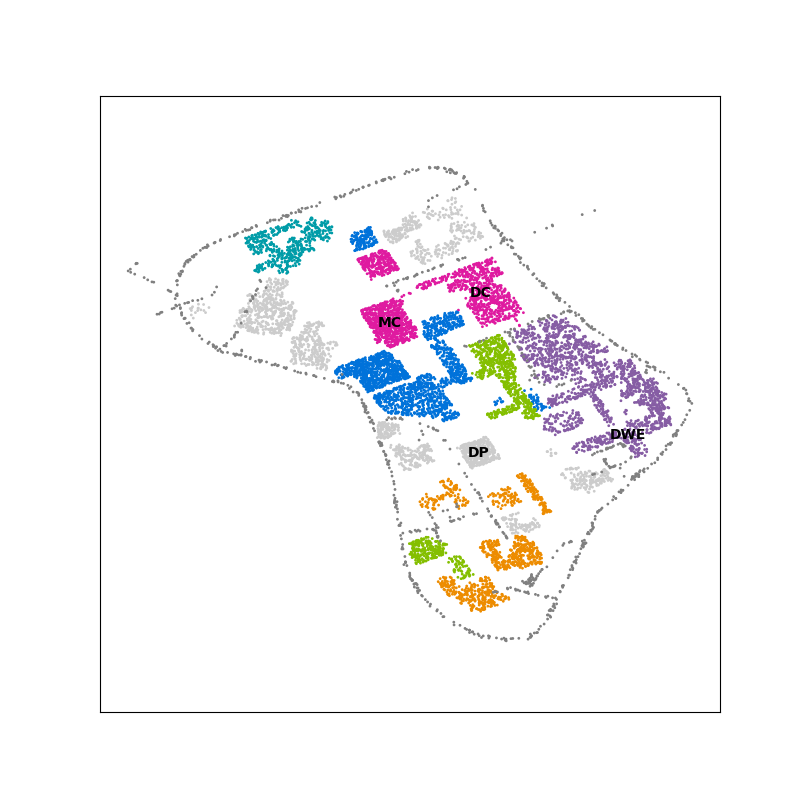

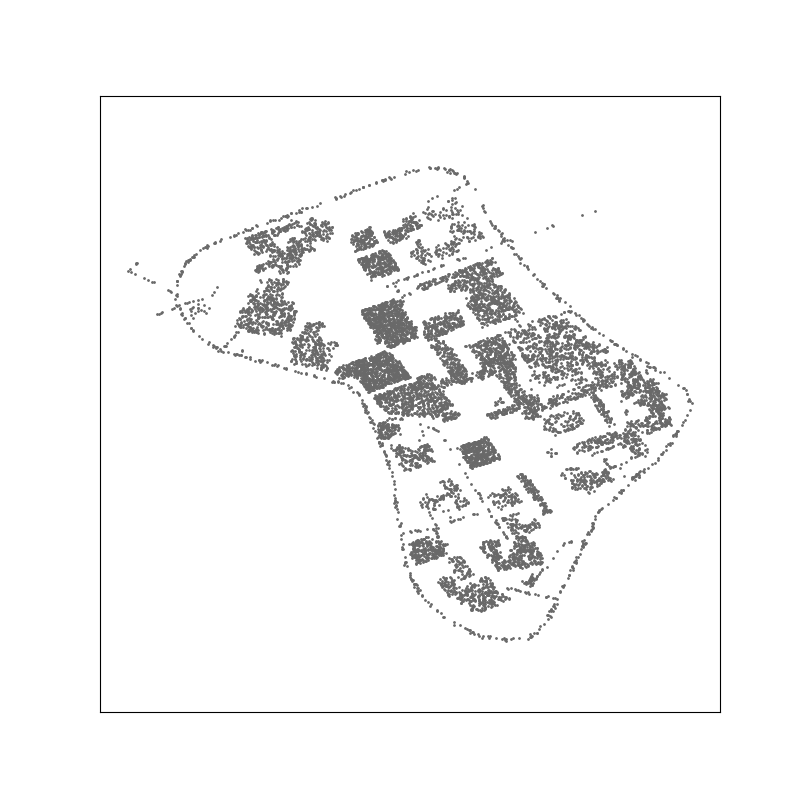

In [42]:
plt.figure(figsize=(8, 8))
plt.scatter(points[:, 0], points[:, 1], c=colors, s=1)

for building in buildings.itertuples():
    if building.OBJECTID in landmarks:
        plt.text(
            building.geometry.centroid.x, building.geometry.centroid.y,
            landmarks[building.OBJECTID],
            fontsize=10, color='black', ha='center', va='center', weight='bold'
        )

plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.show()


# Sampled 
plt.figure(figsize=(8, 8))
plt.scatter(points[:, 0], points[:, 1], c="dimgrey", s=1)

plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.show()

In [40]:
radius = min_radius_for_neighbors(points) * 1.05

In [41]:
city_isomap = PlotResult(embedding_method='Isomap',data=points,dimension=2,radius=radius,n_neighbors=50)
city_isomap.compute_geom()

city_le = PlotResult(embedding_method='LE',data=points,dimension=2,radius=radius, n_neighbors=30)
city_le.compute_geom()

city_lle = PlotResult(embedding_method='LLE',data=points,dimension=2,radius=radius,n_neighbors=100)
city_lle.compute_geom()

city_ltsa = PlotResult(embedding_method='LTSA',data=points,dimension=2,radius=radius,n_neighbors=50)
city_ltsa.compute_geom()

city_tsne = PlotResult(embedding_method='t-SNE',data=points,dimension=2,radius=radius,n_neighbors=50)
city_tsne.compute_geom()

city_umap = PlotResult(embedding_method='Umap',data=points,dimension=2,radius=radius,n_neighbors=50)
city_umap.compute_geom()

KeyboardInterrupt: 

/Users/kevinkang/miniforge3/envs/megaman_works/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


{'figure': <Figure size 800x800 with 1 Axes>}

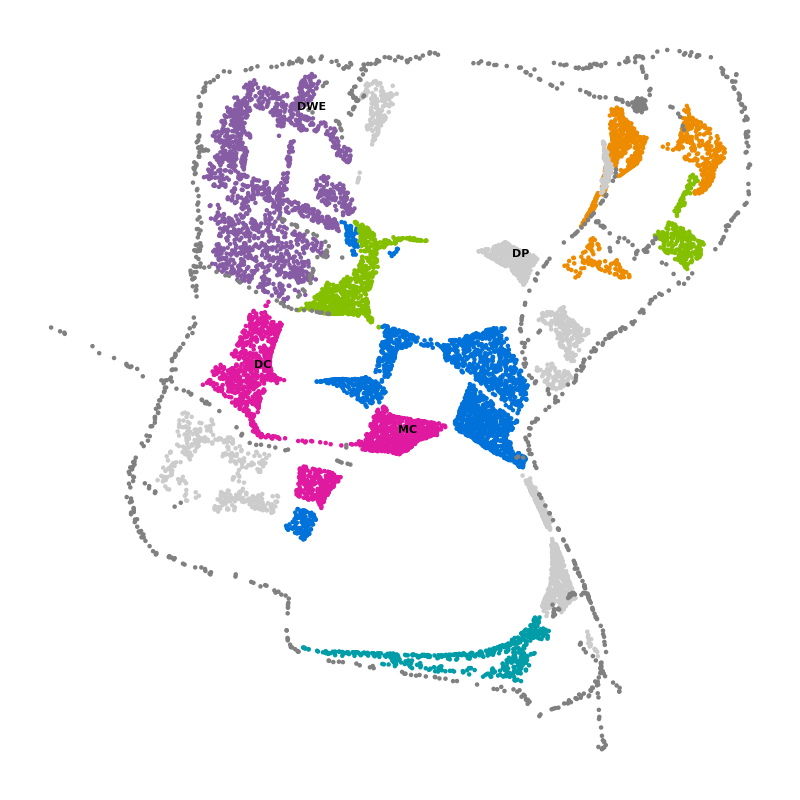

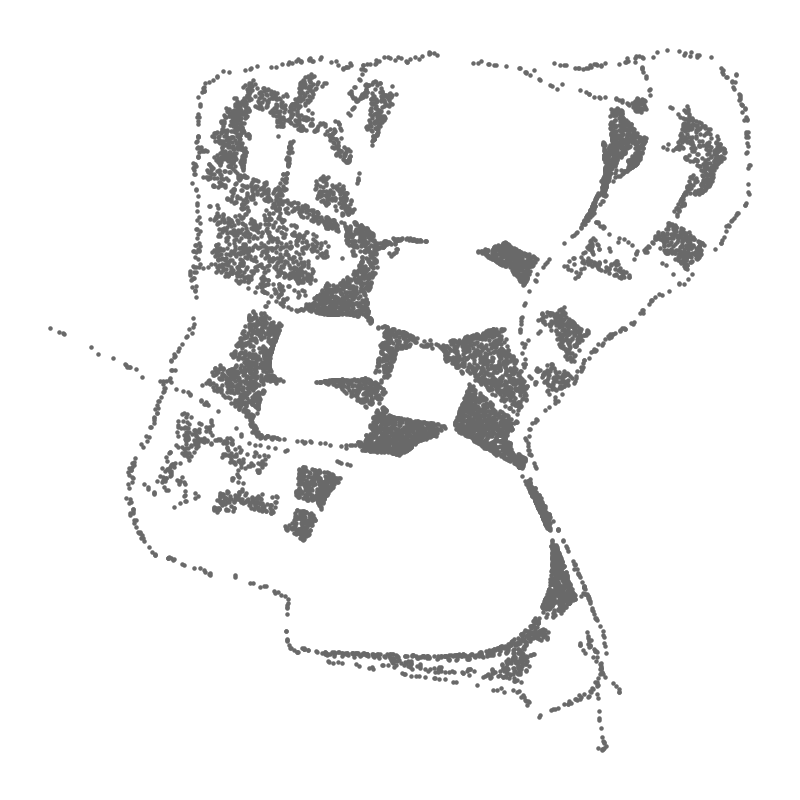

In [ ]:
city_isomap.plot_result(n_plot=20,rellip=0.0025,seed=2014012168,point_color=colors,landmark_indices=landmark_indices,horizontal_flip=True,rotate=-np.pi/2)
city_isomap.plot_result(n_plot=20,rellip=0.0025,seed=2014012168,point_color="dimgray",horizontal_flip=True,rotate=-np.pi/2)
city_isomap.figures

{'figure': <Figure size 800x800 with 1 Axes>}

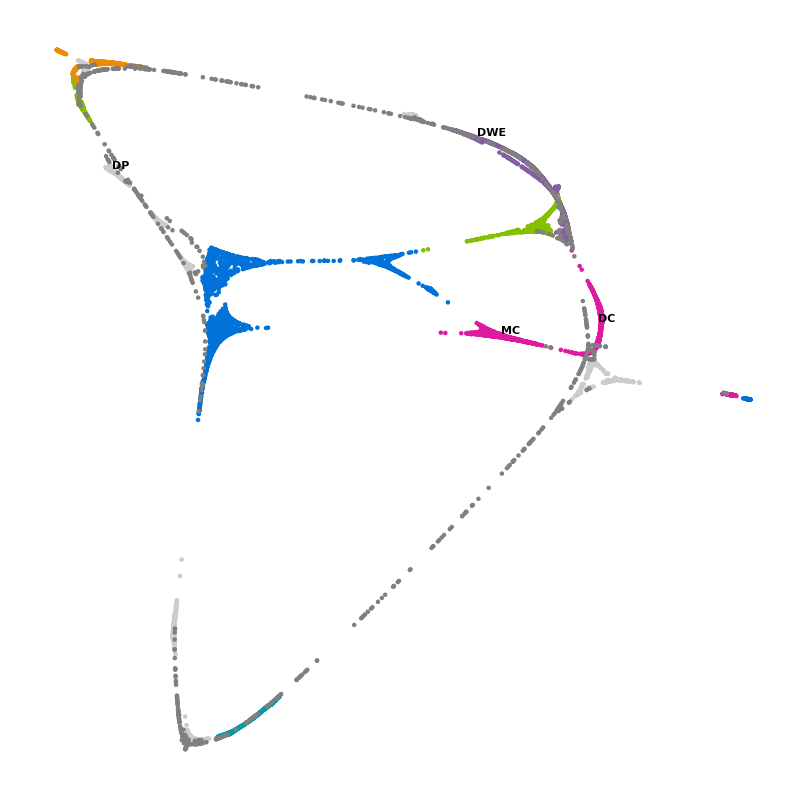

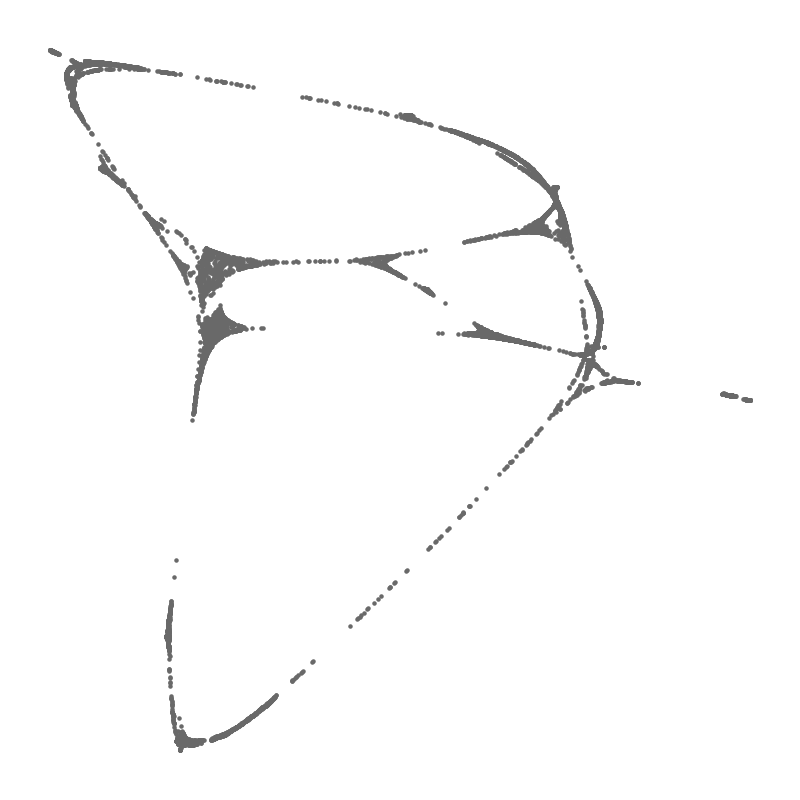

In [ ]:
city_le.plot_result(n_plot=20,rellip=0.0025,seed=2014012168,point_color=colors,landmark_indices=landmark_indices,horizontal_flip=True,rotate=-np.pi/2)
city_le.plot_result(n_plot=20,rellip=0.0025,seed=2014012168,point_color="dimgray",horizontal_flip=True,rotate=-np.pi/2)
city_le.figures

{'figure': <Figure size 800x800 with 1 Axes>}

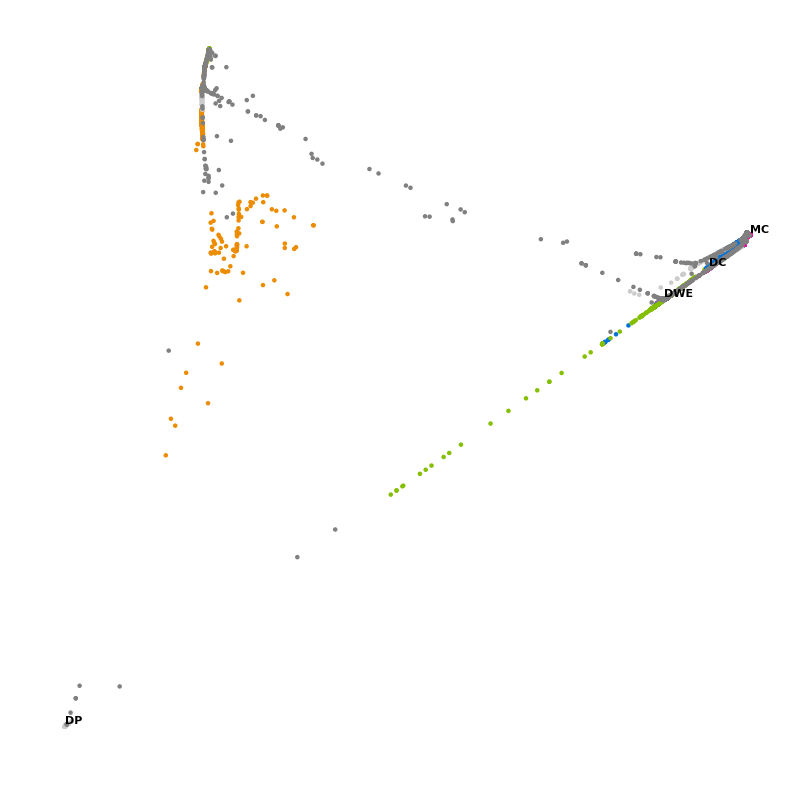

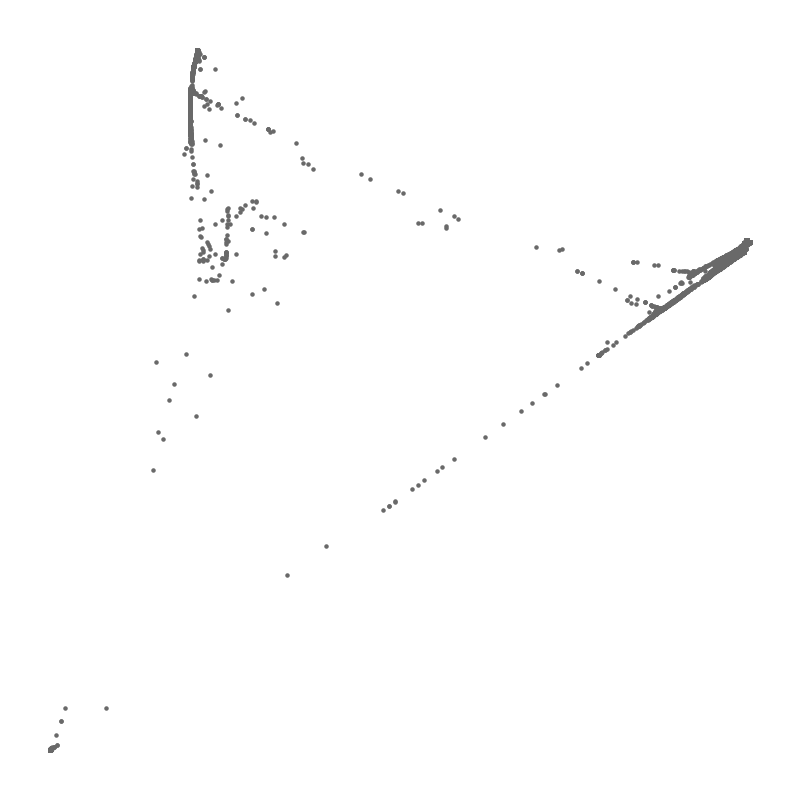

In [ ]:
city_lle.plot_result(n_plot=20,rellip=0.0025,seed=2014012168,point_color=colors,landmark_indices=landmark_indices,horizontal_flip=True)
city_lle.plot_result(n_plot=20,rellip=0.0025,seed=2014012168,point_color="dimgray",horizontal_flip=True)
city_lle.figures

{'figure': <Figure size 800x800 with 1 Axes>}

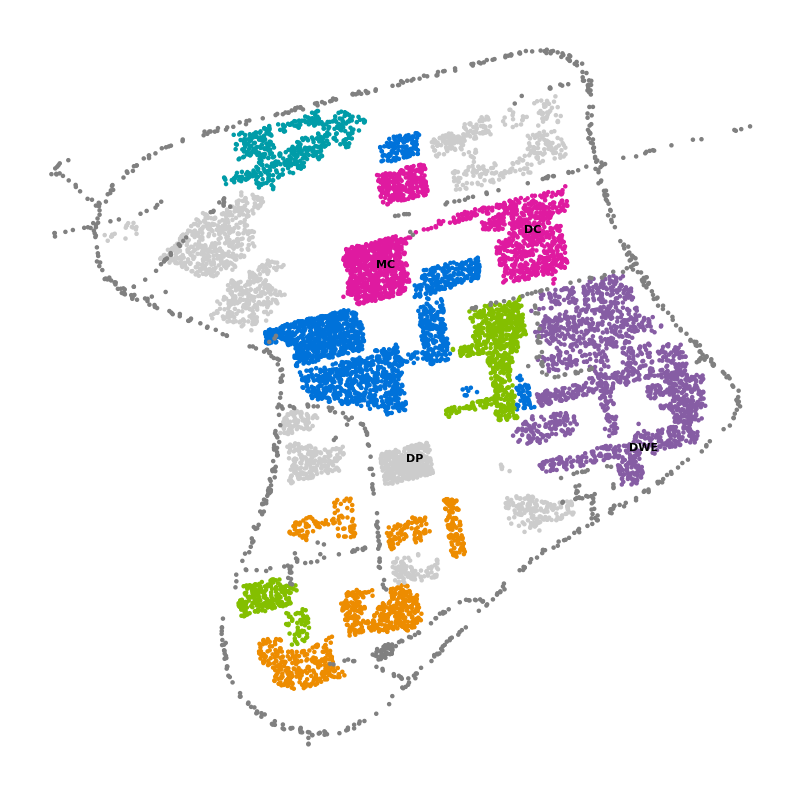

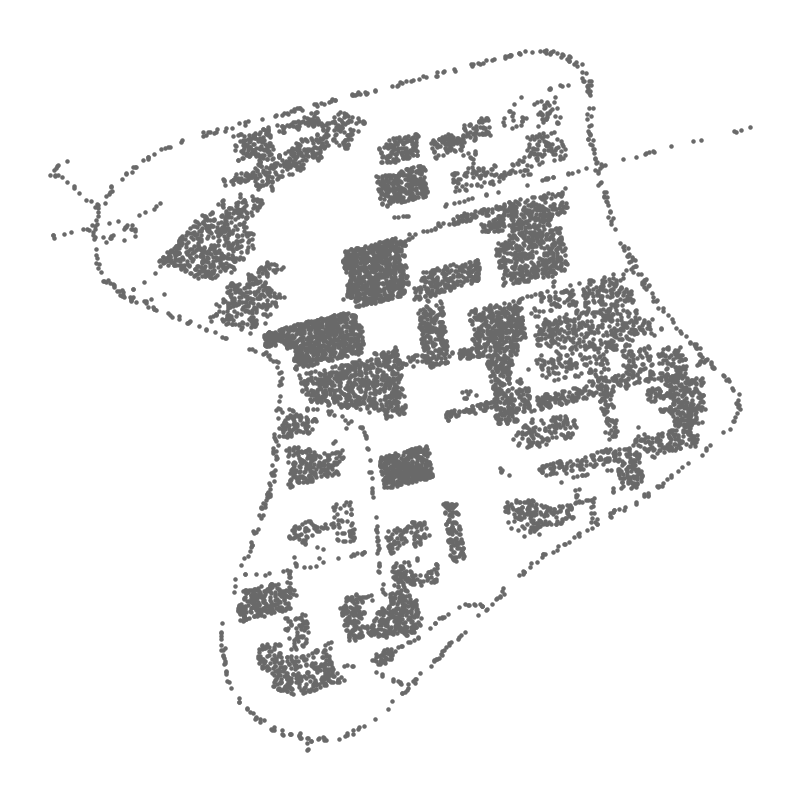

In [ ]:
city_ltsa.plot_result(n_plot=20,rellip=0.0025,seed=2014012168,point_color=colors,landmark_indices=landmark_indices,horizontal_flip=True,rotate=np.pi/2)
city_ltsa.plot_result(n_plot=20,rellip=0.0025,seed=2014012168,point_color="dimgray",horizontal_flip=True,rotate=np.pi/2)
city_ltsa.figures

/Users/kevinkang/miniforge3/envs/megaman_works/lib/python3.6/site-packages/ipykernel_launcher.py:84: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


{'figure': <Figure size 800x800 with 1 Axes>}

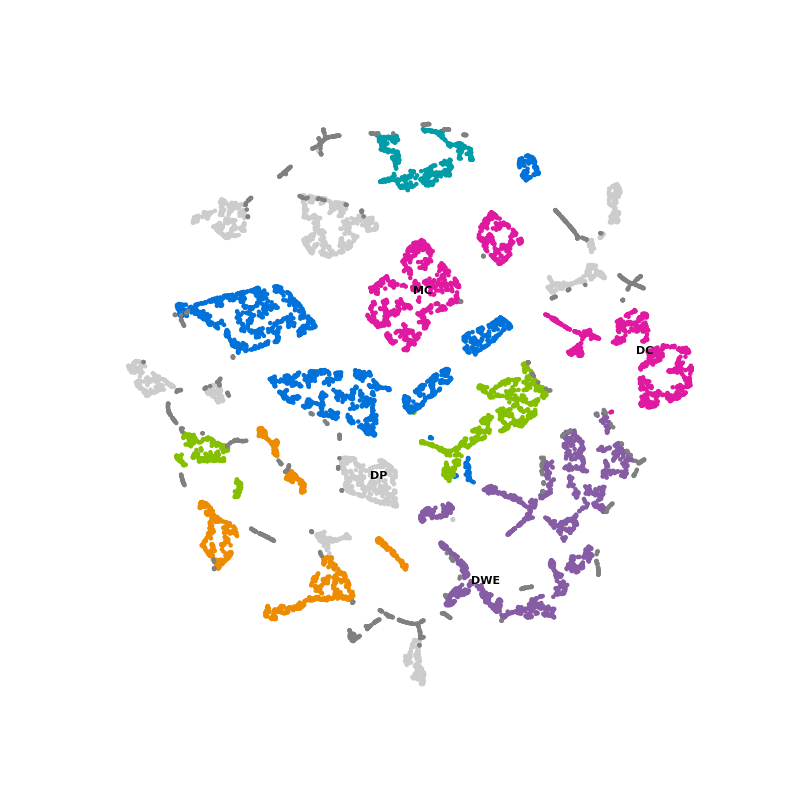

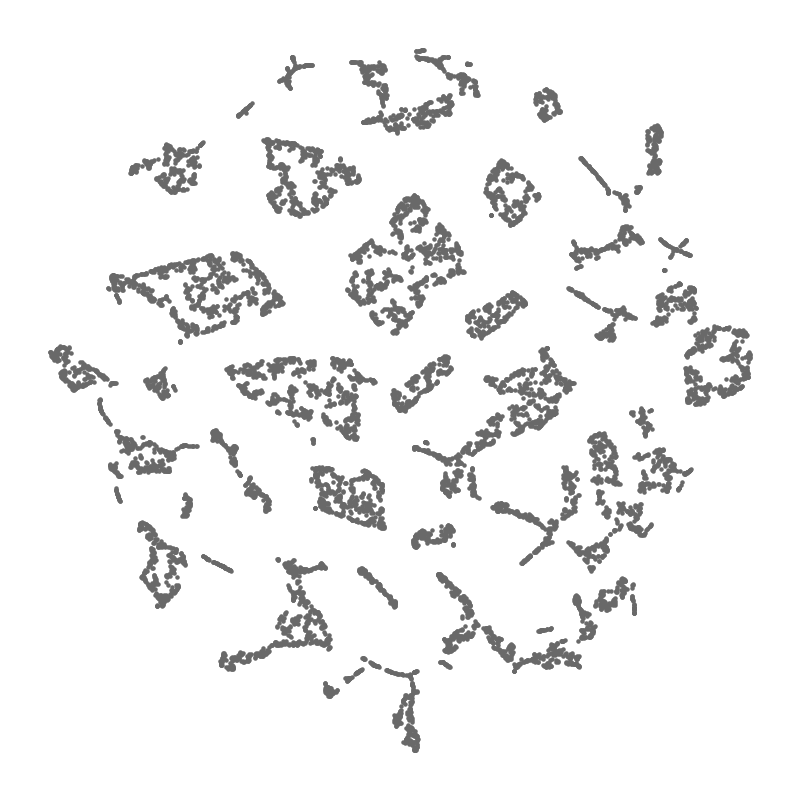

In [ ]:
city_tsne.plot_result(n_plot=20,rellip=0.0025,seed=2014012168,point_color=colors,landmark_indices=landmark_indices,horizontal_flip=True,rotate=np.pi/2)
city_tsne.plot_result(n_plot=20,rellip=0.0025,seed=2014012168,point_color="dimgray",horizontal_flip=True,rotate=np.pi/2)
city_tsne.figures

/Users/kevinkang/miniforge3/envs/megaman_works/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/kevinkang/miniforge3/envs/megaman_works/lib/python3.6/site-packages/ipykernel_launcher.py:84: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


{'figure': <Figure size 800x800 with 1 Axes>}

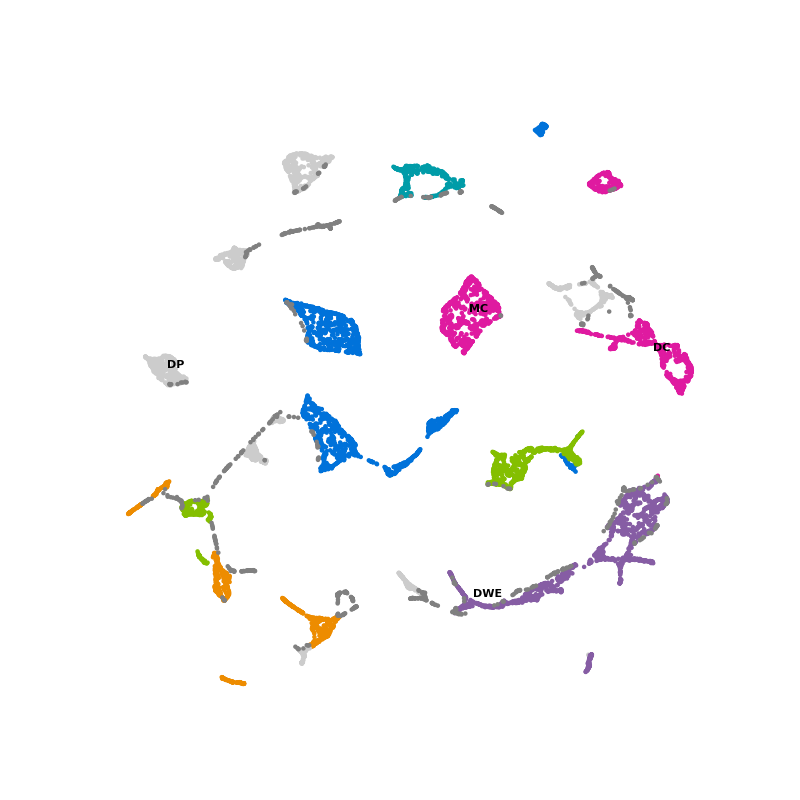

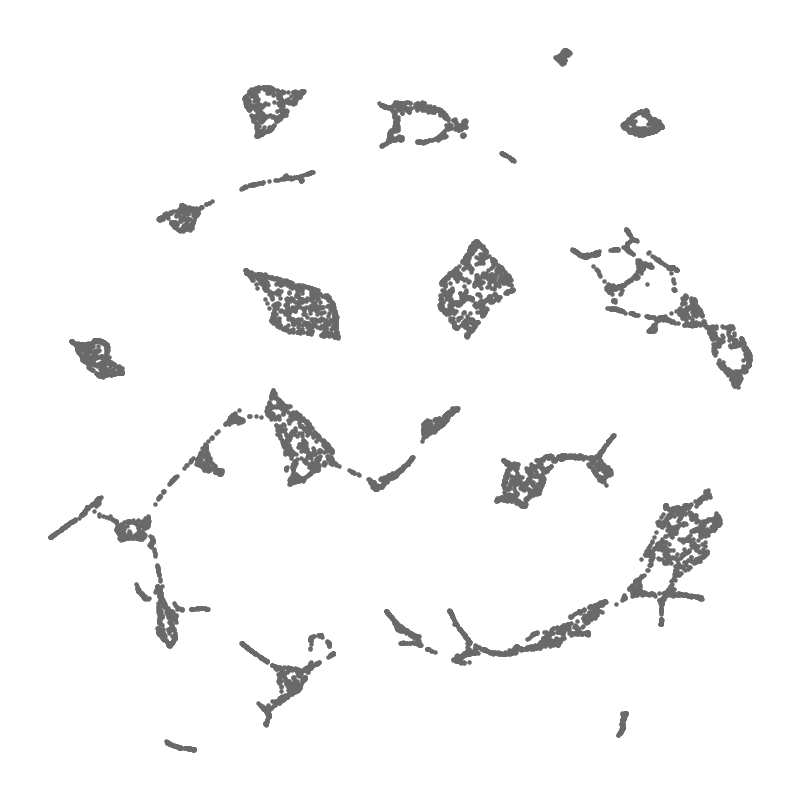

In [ ]:
city_umap.plot_result(n_plot=20,rellip=0.0025,seed=2014012168,point_color=colors,landmark_indices=landmark_indices,horizontal_flip=True,rotate=np.pi/2)
city_umap.plot_result(n_plot=20,rellip=0.0025,seed=2014012168,point_color="dimgray",horizontal_flip=True,rotate=np.pi/2)
city_umap.figures